# Building neural networks with PyTorch

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
import torch # import the PyTorch package
import torchvision # import trochvision package

## PyTorch Tensors - enhanced NumPy arrays

In [7]:
v = torch.Tensor([1, 2, 3])

In [5]:
v

tensor([ 1.,  2.,  3.])

In [6]:
v[0]

tensor(1.)

### Why PyTorch Tensors?

* Tensors can be run on **GPUs**

In [8]:
from torch import nn
import torch.nn.functional as F

# Get the data

We are going to load a **training set** that we are going to use to train our network and a separate **test set** that we'll use to evaluate the performance of the network.

## Loading the training set

We can use convenience methods in `torchvision.datasets` to download various popular machine learning benchmark images. Here we are going to download [**MNIST**](http://yann.lecun.com/exdb/mnist/) which is a collection of handwritten digits along with labels (i.e. what digit was drawn).

The MNIST dataset consists of a total of 70,000 images, of which 60,000 are desginated as the **training set** and 10,000 are designated as the **test set**. This standardized separation allows everyone around the world to evaluate and compare their model's performances with each other!

In [42]:
train_set = torchvision.datasets.MNIST('./data', train=True, download=True)

This returns Torchvision's special **dataset** object that can be used to represent **supervised datasets** consisting of both inputs (i.e. images) and targets (i.e. digit labels).

In [43]:
len(train_set)

60000

In [50]:
image, label = train_set[100]

Text(0.5,1,'Digit: 5')

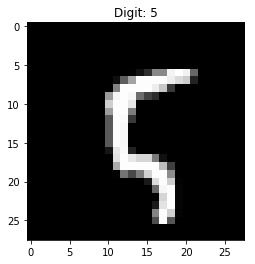

In [51]:
plt.imshow(image)
plt.title('Digit: {}'.format(label))

## Loading the test set

You can get the test set in an identical fashion, passing in `train=False` into `MNIST`:

In [255]:
test_set = torchvision.datasets.MNIST('./data', train=False, download=True)

In [256]:
len(test_set)

10000

In [257]:
image, label = train_set[3]

Text(0.5,1,'Digit: 1')

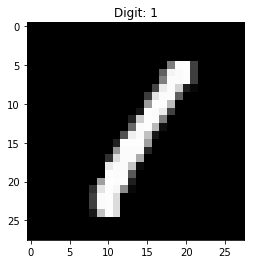

In [258]:
plt.imshow(image)
plt.title('Digit: {}'.format(label))

## Add data transforms

Even before you start feeding in your images into a neural network, it is very common to perform some data transformations - modifying images in some fixed manner that makes it easier to work with them.

One of the most common image transformation is **normalization**, where you first compute mean and standard deviation across all images (typically in the training set). You then subtract the mean from each image and also divide each image by the standard deviation. If you did this, and recomputed the mean and standard deviation across all images, you will find that they now have **mean of 0** and **standard deviation of 1**, and thus they are said to be **normalized**.

Normalization helps ensure input image intensities stay within some expected range, allowing the network to not have to worry about large variations in image values that is otherwise visually uninteresting.

Also, when you load images from Torchvision, they are provided as Pillow package's Image object. Pillow is one of Python's popular image processing package, and there images are represented by a dedicated Image object with a lot of methods implementing common image processing operations.

In [259]:
type(image)

PIL.Image.Image

However, in PyTorch, networks only understands PyTorch Tensors, and thus we must convert the images from Pillow Image into PyTorch Tensor before we can pass the image into the network.

We can achieve these two *transformations* by making use of Torchvision's transformation operations. You combine multiple transformation operations together and pass it at the time of dataset loading. This returns a dataset that **applies these transformations** automatically on all images! 

Let's add a transformation that will:
1. convert images into PyTorch tensors
2. normalize the images against the mean of 0.1307 and standard deviation of 0.3081.

In [56]:
from torchvision import transforms # get torchvision's transforms subpackage

In [57]:
# create a composite transform that first converts images to tensors and then normalize the images
image_transform = transforms.Compose([
    transforms.ToTensor(), # converts images into Tensors
    transforms.Normalize([0.1307], [0.3081])
])

# apply the transforms at the time of dataset loading
training_set = torchvision.datasets.MNIST('./data', train=True, download=True,
                                          transform=image_transform)
test_set = torchvision.datasets.MNIST('./data', train=True, download=True,
                                          transform=image_transform)

Now any image you access through the dataset has the transformation already applied

# Defining your network

In PyTorch, you define a new neural network by defining a **new class that inherits from nn.Module** as follows:

In [211]:
class MyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(5, 10)
        
    def forward(self, x):
        y = self.fc(x)
        z = F.relu(y)
        return z

To understand this better, let's take a quick review of classes and learn the new concept of **object inheritance**.

## Defining a class

In the past session, we have taken a look at defining a **class** to represent a grouping of data and functions, where each **instance of a class** or **object** can be thought of as representing a concrete unit that has **properties** and **behavior** (or **methods**).

In [160]:
class Person:
    def __init__(self, name):
        self.name = name  # assign name
        
    def title(self):
        return "an ordinary person."
    
    def greeting(self):
        print('Hello! My name is {}.'.format(self.name))
        print("I'm {}".format(self.title()))

In [161]:
edgar = Person('Edgar')
john = Person('John')

In [162]:
edgar.greeting()

Hello! My name is Edgar.
I'm an ordinary person.


In [164]:
john.greeting()

Hello! My name is John.
I'm an ordinary person.


Here you can see that both `edgar` and `john` are objects of type (class) `Person`. They both have properties called `name` that is unique to each, and have the common behaviors (method) called `greeting` that prints out a greeting message introducing themselves. Note that `greeting` method calls another method `title` in creating the intro statement.

Key of Object-Oriented Programming (OOP) is to group certain data (e.g. `name`) with behavior (e.g. `greeting`, `title`) that when put together can be used to represent a conceptual grouping that may correspond to some real world *objects*.

## Specialization via inheritance

Now imagine that you want to define a new **class** of object called `Scientist` that has everything that a `Person`  has (e.g.`name`, `greeting`, and `title`), but has extra property called `topic` that specified their research topic, and has a new behavior (i.e. *method*) called `research` that finds a significant result at p-value < 0.05. 

Without worry much about code duplication, you could implement it as such: 

In [165]:
import random

class Scientist:
    def __init__(self, name, topic):
        self.name = name
        self.topic = topic
        
    def title(self):
        return "an ordinary person."
    
    def greeting(self):
        print('Hello! My name is {}.'.format(self.name))
        print("I'm {}".format(self.title()))
 
    def research(self, silent=False):
        print('Performing a research on the topic {}...'.format(self.topic))
        pvalue = random.random() # randomly pick a value between [0, 1)
        
        if pvalue < 0.05:
            if not silent:
                print('Results statistically significant with p-value={:0.3f}!! Publish!!'.format(pvalue))
            return True
        else:
            if not silent:
                print('Results was not significant with p-value={:0.3f}... Continue working...'.format(pvalue))
            return False

In [166]:
edgar = Scientist(name='Edgar', topic='computational neuroscience')

In [167]:
edgar.greeting()

Hello! My name is Edgar.
I'm an ordinary person.


In [168]:
edgar.research()

Performing a research on the topic computational neuroscience...
Results was not significant with p-value=0.793... Continue working...


False

Now notice that there is a lot of repeated code between a `Person` and a `Scientist`. Both has property called `name` and a method called `greeting`. After all, a Scientist **is a** Person, right? When one class can be thought of as a **specialization** of another class, you can save alot of typing and code duplication by using **class inheritance**!

In [169]:
import random

class Scientist(Person):  # Scientist inherits from Person
    def __init__(self, name, topic):
        super().__init__(name)
        self.topic = topic

    def research(self, silent=False):
        print('Performing a research on the topic {}...'.format(self.topic))
        pvalue = random.random() # randomly pick a value between [0, 1)
        
        if pvalue < 0.05:
            if not silent:
                print('Results statistically significant with p-value={:0.3f}!! Publish!!'.format(pvalue))
            return True
        else:
            if not silent:
                print('Results was not significant with p-value={:0.3f}... Continue working...'.format(pvalue))
            return False

In [170]:
moku = Scientist(name='Moku', topic='physics')

In [171]:
edgar.greeting()

Hello! My name is Edgar.
I'm an ordinary person.


In [172]:
edgar.research()

Performing a research on the topic computational neuroscience...
Results statistically significant with p-value=0.048!! Publish!!


True

Notice that the `Scientist` class no longer implements the `greeting` and `eat` methods, yet you can still call them on the instance of `Scientist`. This is because these methods were **inherited** from `Person` class.

Furthermore, we call something funny inside the `__init__` method: `super().__init__(name)`. As you may be able to guess, this calls the initializer of `Person` or the **super class**, passing in the value it expects (e.g. `name` of the person). This allows any complex configuration that `Person` might have done in its `__init__` to be reused.

Finally, you can **override** super class's implementation of a method to give a new, specialized behavior to an existing method! Here, let's **override** the implementation of the method `title`, in effect cusotmizing the introduction:

In [175]:
import random

class Scientist(Person):  # Scientist inherits from Person
    def __init__(self, name, topic):
        super().__init__(name)
        self.topic = topic
        
    # overriding title method
    def title(self):
        return "a scentist in {}".format(self.topic)

    def research(self, silent=False):
        print('Performing a research on the topic {}...'.format(self.topic))
        pvalue = random.random() # randomly pick a value between [0, 1)
        
        if pvalue < 0.05:
            if not silent:
                print('Results statistically significant with p-value={:0.3f}!! Publish!!'.format(pvalue))
            return True
        else:
            if not silent:
                print('Results was not significant with p-value={:0.3f}... Continue working...'.format(pvalue))
            return False

In [176]:
edgar = Scientist(name='Edgar', topic='computational neuroscience')

In [177]:
edgar.greeting()

Hello! My name is Edgar.
I'm a scentist in computational neuroscience


You can see that we were able to modify the behaivor of an already existing method `greeting` by overriding the behavior of the another method `title`. This pattern in which you can **customize** behavior of an already existing mechanism by overriding another method happens quite commonly. In fact, we will soon encounter them in implementing our neural network in PyTorch!!

## Networks inherit from *nn.Module*

Now armed with knowlege of class inheritance, let's take another look at a typical definition of a neural network in PyTorch. In PyTorch, any network **is a** `nn.Module`. In other words, you define a new class that inherits from `nn.Module`.

In [187]:
class MyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(5, 10)
        
    def forward(self, x):
        y = self.fc(x)
        z = F.relu(y)
        return z

Above, we can see that `MyNetwork` *inherits from* `nn.Module`. This gives our class `MyNetwork` with a lot of properties and methods that is already part of `nn.Module`, and this is precisely what allows you to define a new neural network with minimal work. 

A network in PyTorch (which is a class), typically consists of one or more **layers** that you create and hold on to inside the `__init__` method. Here, we are defining a single `nn.Linear` layer which corresponds to a *fully-connected* linear layer connecting from 5 input nodes into 10 output nodes. We **instantiate** this layer and assign it to the object's property named `fc` (standing for **f**ully **c**onnected layer).

Note that in the `__init__`, we have not computed anything. We simply instantiated a layer and assigned it to a property for *later use*.

Real use of a PyTorch module comes in when you **instantiate** the class - that is, you create an object:

In [188]:
net = MyNetwork()

This action just created a new **instance** of the network, with it's own network weights that can be trained!

A key feature of a module is the fact that you can use it like a function - it accepts an input and returns an output!

In [189]:
x = torch.rand(1, 5) # a simple vector of 5 elements - or 5 input values

y = net(x) # you use a module instance like a function!

y

tensor([[ 0.0695,  0.4837,  0.0000,  0.0000,  0.2656,  0.0000,  0.0172,
          0.0000,  0.3369,  0.0000]])

In [186]:
y.shape

torch.Size([1, 10])

The secret behind this is the `forward` method we defined in the `MyNetwork` class:

```python
 def forward(self, x):
    y = self.fc(x)
    z = F.relu(y)
    return z
```

In this method, we accepted a parameter `x`, and we used the fully-connected linear layer `self.fc` as a function with `x` as the input!

It turns out that `nn.Linear` is yet another **subclass** of `nn.Module` and thus can take input, return output. Our particular `self.fc` was configured to take in input of size 5 and output vector of size 10.

The `F.relu` is then an element-wise operation that clips any value less than 0 to 0, while keeping positive values as is. `forward` function finally returns the output of `relu` and that becomes the output of the whole network.

All in all, `MyNetwork` implemented a **single full-connected layer neural network with ReLU output non-linearity** - one of the simplest networks you can construct!

## Building network to classify images into digits 

Now we have seen how to build a network by defining a new class that inherits from `nn.Module`, let's try to implement a network that takes in a $28 \times 28$ pixels gray scale image of a digit and classifies them into 1 of 10 digits!

The input will be one or more images of size $28 \times 28$, and we are going to set **the output to be a vector of size 10** where each position indicates a *log probability* that the image belongs to the specific digit.

We'll start with a simplest possible implementation where we **flatten out** the input image into a vector of size 28 * 28 = 784. This will be **fully connected neural network with no output nonlinearity** linking 784 input nodes into 10 output nodes.

In [199]:
class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784, 10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # flattens an image of form N x 1 x 28 x 28 -> N x 784
        x = self.fc(x)
        x = F.log_softmax(x, dim=1) # make sure that probabilities add up to one, and then take log
        return x

And that's it!

Let's instantiate the network and run an image through it:

In [200]:
net = SimpleNetwork()

In [201]:
image, label = test_set[30]

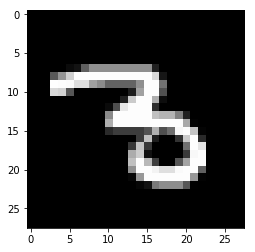

In [210]:
plt.imshow(image.squeeze(), cmap='gray')

In [209]:
net(image)

tensor([[-1.9762, -2.1093, -2.4735, -2.6918, -3.4270, -3.2984, -1.9790,
         -2.4868, -1.4873, -2.6417]])

This is a log of class probabilities, so we can exponentiate this to get the actual probability over classes:

In [203]:
torch.exp(net(image))

tensor([[ 0.1386,  0.1213,  0.0843,  0.0678,  0.0325,  0.0369,  0.1382,
          0.0832,  0.2260,  0.0712]])

We can perhaps take the index with the largest probability as the network's best guess:

In [205]:
p = torch.exp(net(image))
torch.argmax(p)

tensor(8)

But the label is:

In [206]:
label

tensor(3)

So you can see that our network is not quite performing well. That's expected because our network is **randomly initialized**! In order to get a reasonable performance, we need to **train** the network!

# Training a neural network

We are going to **train our network** by minimizing a **loss function** - a function that evaluates how *off* we are from the true target of the world. Chosing a good loss function can influence how well your network performs.

In the case of **N-way classification** problem where the output is a vector of size *N*, it's quite common to treat the output as the log probability of N classes, and optimize the network by miniminzg **negative log likelihood**. 

This is conceptually similar to adjusting the network weights (parameters) so that the correct class would have the higest probability among choices.

In training a neural network, you would follow a procedure called **gradient descent** to adjust the values of the network weights such that the loss function becomes smaller.

One of the biggest strenghts of frameworks like PyTorch lies in the fact **it can compute gradient of the loss with respect to all parameters in the network automatically** for you!

#### On gradient descent and back propagation

To compute the gradient of the loss with respect to the weights, neural network packages like PyTorch (and pretty much any other similar packages) make use of technique called **back propagation**. Covering the details of gradient descent and how back propagation exactly works are outside the scope of this course. Interested readers are strongly encouraged to refer to wonderful online resources such as [Neural Network and Deep Learning](http://neuralnetworksanddeeplearning.com/) online text book by Michael Nielson.

## Training on a minibatch

In a full-fledged optimization problem, you will typically evaluate the loss on **all training dataset** and try to **optimize the joint loss**. However, this requires computing the loss on all images everytime you make a small modification to the parameters, and for complex neural networks, this computational cost can be extremely prohibitive.

Hence, you would typically **estimate** the joint loss by evaluating the loss on a randomly selected subsets of the input-target pairs, or on **a minibatch** (or simply a batch) of data.

Performing gradient descent on randomly sampled subsets of the training set is known as (minibatch) **stochastic gradient descent** (SGD).

To be able to perform minibatch SGD, we need a way to construct a random minibatch from the training datasets. Fortunately, this is easy to achive using PyTorch's `DataLoader`

In [222]:
batch_size = 64
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size) # by default shuffle is False

`DataLoader` is an iterable, that returns batches of input target pairs of specified *batch size*. We can take a look at what it will return by calling `next` on it:

In [223]:
for x, t in training_loader:
    print('Images:', x.shape)
    print('Labels:', t.shape)
    break # quit after one iteration

Images: torch.Size([64, 1, 28, 28])
Labels: torch.Size([64])


Note that for both the images (inputs) and the labels (targets), the **first dimension is the batch dimension**.

## Iterating through the minibatch

Now we know how to get a minibatch, let's start putting together a training framework:

In [225]:
net = SimpleNetwork()
net.train() # puts the network into the training mode

for batch_idx, (data, target) in enumerate(training_loader):
    # evaluate the network output
    output = net(data)
    
    # compute the loss
    loss = F.nll_loss(output, target)
    
    # MISSING! Perform back propagation to compute gradient and perform gradient descent step!

The above code successuflly steps through 60,000 training images in batch of 64, evaluate the network on the inputs, and computes the loss between the network prediction and the targets. 

However, we are still missing the step of computing the gradient of loss with respect to the parameters of the network, and performing gradient descent to actually adjust and therefore **train** the network parameters!

We achieve this by using:

1. `backward` method call on the finall loss to trigger backpropagation computation, and 
2. An **optimizer** to adjust the values of the parameters based on the gradient

Putting this all together:

In [226]:
net = SimpleNetwork()
net.train() # puts the network into the training mode

# create and initialize an optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

for batch_idx, (data, target) in enumerate(training_loader):
    # reset the gradient before the next gradient step
    optimizer.zero_grad()
    
    # evaluate the network output
    output = net(data)
    
    # compute the loss
    loss = F.nll_loss(output, target)
    
    # perform back propagation to compute gradients with respect to parameters!
    loss.backward()
    
    # perform a gradient descent step on the parameters
    optimizer.step()

The final missing piece is some sort of **monitoring** by which we can observe that the network is actually training (that is, the loss decreases over training).

In [241]:
net = SimpleNetwork()
net.train() # puts the network into the training mode

# create and initialize an optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.005)

for batch_idx, (data, target) in enumerate(training_loader):
    # reset the gradient before the next gradient step
    optimizer.zero_grad()
    
    # evaluate the network output
    output = net(data)
    
    # compute the loss
    loss = F.nll_loss(output, target)
    
    # perform back propagation to compute gradients with respect to parameters!
    loss.backward()
    
    # perform a gradient descent step on the parameters
    optimizer.step()
    
    # report the loss every 100 batches
    if batch_idx % 100 == 0:
        print('Loss: {:.6f}'.format(loss.item()))

Loss: 2.534343
Loss: 0.816979
Loss: 0.542766
Loss: 0.726783
Loss: 0.331407
Loss: 0.422346
Loss: 0.351978
Loss: 0.291532
Loss: 0.455459
Loss: 0.251536


We see that indeed our network appears to train over time as shown by the fact loss decreses over iterations. You can also see that loss eventually stop decreasing when the training reaches the end.

You can adjust the speed of the training by changing the value of the **learning rate**. Loosely speaking, learning rate controls the size of the step you step in each gradient descent step. 

Larger learning rate could lead to faster training but it can also easily stray youself away from an optimal solution. Achieving a good network training depends a lot on a good choice of the value of the learning rate.

## Testing the network

Now we have a trained network, it's time to evaluate it's performance on the test set. Training on one set and testing on a distinct set that was **not** used during the training is called **cross-validation**, and can be a good way to evaluate how well your network will **generalize** beyond the training set.

In [242]:
net.eval() # put network into evaluation model
test_loss = 0
correct = 0

# prevents unnecessary gradient computation during test - can lead to time and memory saving
with torch.no_grad(): 
    for data, target in test_loader:
        output = net(data)
        
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).item() 
        
        # get the index of the max log-probability
        pred = output.max(1, keepdim=True)[1] 
        
        # count number of times where max probability matches the label index
        correct += pred.eq(target.view_as(pred)).sum().item()

# divide the test loss by number of samples in the test set
test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.3928, Accuracy: 53447/60000 (89%)



You should see that our network actually performs ~84-90% correct on the digit classification!

Let's take the earlier example:

In [231]:
image, label = test_set[30]

In [232]:
label

tensor(3)

In [234]:
p = torch.exp(net(image))
torch.argmax(p)

tensor(3)

# Training a more complex network

Above we were already getting well above chance performance on digit classification with an extremely simple **single fully-connected layer network**. Now, let's try improving the result by training slight more complex network - **three layer fully-connected network with ReLU nonlinearity**.

In [235]:
class ComplexNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # flattens an image of form N x 1 x 28 x 28 -> N x 784
        x = F.relu(self.fc1(x)) # first fully connected layer followed by ReLU
        x = F.relu(self.fc2(x)) # second fully connected layer followed by ReLU
        x = self.fc3(x) # third fully connected layer *without* output ReLU
        x = F.log_softmax(x, dim=1) # make sure that probabilities add up to one, and then take log
        return x

Let's not go ahead and train it!

In [244]:
net = ComplexNetwork()
net.train() # puts the network into the training mode

# create and initialize an optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.005)

for batch_idx, (data, target) in enumerate(training_loader):
    # reset the gradient before the next gradient step
    optimizer.zero_grad()
    
    # evaluate the network output
    output = net(data)
    
    # compute the loss
    loss = F.nll_loss(output, target)
    
    # perform back propagation to compute gradients with respect to parameters!
    loss.backward()
    
    # perform a gradient descent step on the parameters
    optimizer.step()
    
    # report the loss every 100 batches
    if batch_idx % 100 == 0:
        print('Loss: {:.6f}'.format(loss.item()))

Loss: 2.260793
Loss: 2.121841
Loss: 1.914793
Loss: 1.571293
Loss: 1.103959
Loss: 0.857417
Loss: 0.685158
Loss: 0.515869
Loss: 0.545789
Loss: 0.567869


You should notice two things:
1. It trains much slower! and
2. The loss is still decreasing at the end of the training.

It is slower because the nework is more complex and it requires much more computations. To deal with the fact that it is still decreasing, we should not limit ourselves to a single pass through our training set, but rather go through numerous pass through it. Each complete pass through the training set is called **an epoch**, so here we want to perform **multiple epoch** training!

In [246]:
net = ComplexNetwork()
net.train() # puts the network into the training mode

# create and initialize an optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.005)

for epoch_idx in range(5):
    for batch_idx, (data, target) in enumerate(training_loader):
        # reset the gradient before the next gradient step
        optimizer.zero_grad()

        # evaluate the network output
        output = net(data)

        # compute the loss
        loss = F.nll_loss(output, target)

        # perform back propagation to compute gradients with respect to parameters!
        loss.backward()

        # perform a gradient descent step on the parameters
        optimizer.step()

        # report the loss every 100 batches
        if batch_idx % 100 == 0:
            print('Epoch {} Loss: {:.6f}'.format(epoch_idx, loss.item()))

Epoch 0 Loss: 2.320441
Epoch 0 Loss: 2.113369
Epoch 0 Loss: 1.858312
Epoch 0 Loss: 1.407332
Epoch 0 Loss: 1.143449
Epoch 0 Loss: 0.923603
Epoch 0 Loss: 0.662661
Epoch 0 Loss: 0.707626
Epoch 0 Loss: 0.493586
Epoch 0 Loss: 0.470204
Epoch 1 Loss: 0.587930
Epoch 1 Loss: 0.495217
Epoch 1 Loss: 0.349844
Epoch 1 Loss: 0.402586
Epoch 1 Loss: 0.542727
Epoch 1 Loss: 0.418397
Epoch 1 Loss: 0.283267
Epoch 1 Loss: 0.326697
Epoch 1 Loss: 0.344775
Epoch 1 Loss: 0.342889
Epoch 2 Loss: 0.352867
Epoch 2 Loss: 0.266470
Epoch 2 Loss: 0.329063
Epoch 2 Loss: 0.264309
Epoch 2 Loss: 0.202597
Epoch 2 Loss: 0.302214
Epoch 2 Loss: 0.264094
Epoch 2 Loss: 0.276803
Epoch 2 Loss: 0.283225
Epoch 2 Loss: 0.295514
Epoch 3 Loss: 0.146708
Epoch 3 Loss: 0.312303
Epoch 3 Loss: 0.234566
Epoch 3 Loss: 0.300298
Epoch 3 Loss: 0.180963
Epoch 3 Loss: 0.271392
Epoch 3 Loss: 0.459493
Epoch 3 Loss: 0.214845
Epoch 3 Loss: 0.262167
Epoch 3 Loss: 0.267412
Epoch 4 Loss: 0.267329
Epoch 4 Loss: 0.235646
Epoch 4 Loss: 0.263253
Epoch 4 Los

In [247]:
net.eval() # put network into evaluation model
test_loss = 0
correct = 0

# prevents unnecessary gradient computation during test - can lead to time and memory saving
with torch.no_grad(): 
    for data, target in test_loader:
        output = net(data)
        
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).item() 
        
        # get the index of the max log-probability
        pred = output.max(1, keepdim=True)[1] 
        
        # count number of times where max probability matches the label index
        correct += pred.eq(target.view_as(pred)).sum().item()

# divide the test loss by number of samples in the test set
test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.2466, Accuracy: 55753/60000 (93%)



## Much more complex network

Here is a much more complex network (although still would be considered very simple from the field's standard) that uses operations like **convolution** and **drop outs**. (Covering these opartions is beyond the scope of this course but you can find tons of references on them.)

In [250]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [252]:
net = Net()
net.train() # puts the network into the training mode

# create and initialize an optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.5)

for epoch_idx in range(10):
    for batch_idx, (data, target) in enumerate(training_loader):
        # reset the gradient before the next gradient step
        optimizer.zero_grad()

        # evaluate the network output
        output = net(data)

        # compute the loss
        loss = F.nll_loss(output, target)

        # perform back propagation to compute gradients with respect to parameters!
        loss.backward()

        # perform a gradient descent step on the parameters
        optimizer.step()

        # report the loss every 100 batches
        if batch_idx % 100 == 0:
            print('Epoch {} Loss: {:.6f}'.format(epoch_idx, loss.item()))

Epoch 0 Loss: 2.342847
Epoch 0 Loss: 2.149011
Epoch 0 Loss: 1.522278
Epoch 0 Loss: 0.739555
Epoch 0 Loss: 0.912529
Epoch 0 Loss: 0.745104
Epoch 0 Loss: 0.576485
Epoch 0 Loss: 0.645698
Epoch 0 Loss: 0.293432
Epoch 0 Loss: 0.514020
Epoch 1 Loss: 0.371585
Epoch 1 Loss: 0.333495
Epoch 1 Loss: 0.330696
Epoch 1 Loss: 0.449758
Epoch 1 Loss: 0.321991
Epoch 1 Loss: 0.455858
Epoch 1 Loss: 0.357260
Epoch 1 Loss: 0.316326
Epoch 1 Loss: 0.297177
Epoch 1 Loss: 0.442172
Epoch 2 Loss: 0.394849
Epoch 2 Loss: 0.206427
Epoch 2 Loss: 0.305661
Epoch 2 Loss: 0.340804
Epoch 2 Loss: 0.740139
Epoch 2 Loss: 0.276811
Epoch 2 Loss: 0.292988
Epoch 2 Loss: 0.425271
Epoch 2 Loss: 0.168602
Epoch 2 Loss: 0.263998
Epoch 3 Loss: 0.205135
Epoch 3 Loss: 0.201637
Epoch 3 Loss: 0.378599
Epoch 3 Loss: 0.265469
Epoch 3 Loss: 0.316506
Epoch 3 Loss: 0.177646
Epoch 3 Loss: 0.129650
Epoch 3 Loss: 0.210935
Epoch 3 Loss: 0.244079
Epoch 3 Loss: 0.192322
Epoch 4 Loss: 0.366677
Epoch 4 Loss: 0.123705
Epoch 4 Loss: 0.192520
Epoch 4 Los

In [253]:
net.eval() # put network into evaluation model
test_loss = 0
correct = 0

# prevents unnecessary gradient computation during test - can lead to time and memory saving
with torch.no_grad(): 
    for data, target in test_loader:
        output = net(data)
        
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).item() 
        
        # get the index of the max log-probability
        pred = output.max(1, keepdim=True)[1] 
        
        # count number of times where max probability matches the label index
        correct += pred.eq(target.view_as(pred)).sum().item()

# divide the test loss by number of samples in the test set
test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0586, Accuracy: 58962/60000 (98%)

